### Creacion de datos
---
* Crear datos para pruebas, aplicar una convolucion gausiana (PSF) al mapa de santiago con el punto central en donde se midio ..

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc,sys,time

MASK_VALUE = -1.

In [1]:
from netCDF4 import Dataset
#dataset = Dataset('../HC_TOT.nc',mode='r') 
dataset = Dataset('sample_files//NOx_TOT.nc',mode='r') 
print("Dimensiones: ",dataset.dimensions.keys() )
measure = dataset.variables['NOxTOT']
measure_data = measure[:]
W,H = measure.shape
print("HC TOT unit: ",measure.units)
print("HC TOT min value: ",measure.min)
print("HC TOT max value: ",measure.max)
print("HC TOT shape: ",measure.shape)

lons = dataset.variables['longitude']
lons_data = lons[:]

lats = dataset.variables['latitude']
lats_data = lats[:]

#aprox square over santiago --- coordinates
start_long = lons_data[635]
end_long = lons_data[675]

start_lat = lats_data[1575]
end_lat = lats_data[1625]

print("Start longitude %f - End Longitute %f"%(start_long,end_long))
print("Start latitude %f - End latitude %f"%(start_lat,end_lat))

precision_degrees = 0.01

dataset.close()

Dimensiones:  odict_keys(['longitude', 'latitude'])
HC TOT unit:  ton/yr
HC TOT min value:  0.0
HC TOT max value:  282.272216797
HC TOT shape:  (3913, 1157)
Start longitude -70.867122 - End Longitute -70.467122
Start latitude -33.197764 - End latitude -33.697764


In [2]:
W , H = 40, 50

In [5]:
folder = "../proyecto/datasets/"

df_independencia_verano = pd.read_csv(folder+"dump-Independencia_2018-04-12_230000-verano.csv")
df_independencia_invierno = pd.read_csv(folder+"dump-Independencia_2018-04-12_230000-invierno.csv")

df_condes_verano = pd.read_csv(folder+"dump-Las_Condes_2018-04-12_230000-verano.csv")
df_condes_invierno = pd.read_csv(folder+"dump-Las_Condes_2018-04-12_230000-invierno.csv")

df_independencia_invierno.head()

,registered_on,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3
0,1997-05-01 01:00:00,1.1,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1997-05-01 02:00:00,1.6,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1997-05-01 03:00:00,1.9,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1997-05-01 04:00:00,2.2,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1997-05-01 05:00:00,1.7,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [6]:
#latitude and longitude coordinates
LC_lat = -33.414429
LC_long = -70.557030
IND_lat = -33.422390
IND_long =  -70.655200


LC_i = int(round((LC_lat-start_lat)/precision_degrees))
LC_j = int(round((LC_long-start_long)/precision_degrees))

IND_i = int(round((IND_lat-start_lat)/precision_degrees))
IND_j = int(round((IND_long-start_long)/precision_degrees))

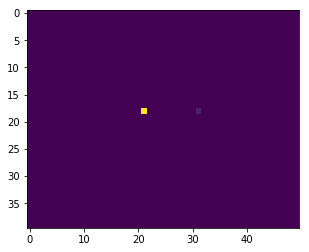

In [7]:

a = np.zeros((W,H))

a[LC_i,LC_j] = 10
a[IND_i,IND_j] =100

plt.imshow(a)
plt.show()

In [8]:
## representacion
rows_to_use = ["CO","PM10","PM25","NO2","NO","NOX","SO2","WD","RH","TEMP","WS","HCNM","UVA","UVB","O3"]
from keras.preprocessing.sequence import pad_sequences

def create_sequences(dataframe,lag=1):
    #preprocesamiento asumiendo dataset es una secuencia
    timestep = dataframe.loc[:,"registered_on"].values
    
    indices_orden = []
    diax = timestep[0].split("-")[-1].split(" ")[0]
    aux_indices1 = 0
    aux_indices2 = 0 
    for dato in timestep[1:]:
        nuevo_dia = dato.split("-")[-1].split(" ")[0]
        aux_indices2+=1
        if diax != nuevo_dia:
            diax = nuevo_dia
            #if aux_indices2-aux_indices1==24:
            #    aux_indices2-=1
            indices_orden.append([aux_indices1,aux_indices2])
            aux_indices1 = aux_indices2
    indices_orden.append([aux_indices1,aux_indices2+1])
    data = dataframe.loc[:,rows_to_use].values
    data = np.asarray([data[init:finit] for init,finit in indices_orden])
    
    horas = 24
    
    dataX = []
    dataY =[]
    for t_plus_1 in range(lag,len(data)):
        #se crea el Y (target)
        predecir = data[t_plus_1][:,-1] #todas las ultimas columnas --sequence
        dataY.append(predecir)
        columnasX = [] #se crea el X (inputs) columnas para predecir Y
        for i in np.arange(lag,0,-1): #para los valores anteriores al t_plus_1 durante un lag
            columnasX.append( data[t_plus_1-i] )
        dataX.append(columnasX)
    
    #mascara delete..
    mask_delete = np.ones(len(dataY),dtype=bool)
    for i,dato in enumerate(dataY):
        if np.any(np.isnan(dato)): #uno en sequencia---algun nulo
            mask_delete[i] = False #eliminar de training
        
    aux = [ np.concatenate(datito) for datito in dataX] #junta los lag..
    #pad
    mask = np.full(len(rows_to_use) , np.nan)
    dataX = pad_sequences(aux, maxlen=lag*horas, dtype='float32', padding='pre', value=mask) #rellena 
    dataY = pad_sequences(dataY, maxlen=horas, dtype='object', padding='post', value=np.nan) #rellena 
    return np.array(dataX)[mask_delete],np.array(dataY)[mask_delete]

Using TensorFlow backend.


In [9]:
lag = 2
trainX1_cond, trainY1_cond = create_sequences(df_condes_verano, lag)
trainX2_cond, trainY2_cond = create_sequences(df_condes_invierno, lag)

trainX1_inv, trainY1_inv = create_sequences(df_independencia_verano, lag)
trainX2_inv, trainY2_inv = create_sequences(df_independencia_invierno, lag)

#testX1_cond, testY1_cond = create_sequences(df_condes_verano_test, lag,dia)
#testX2_cond, testY2_cond = create_sequences(df_condes_invierno_test, lag,dia)

print("All arrays shapes Condes")
print("Train verano (input): ",trainX1_cond.shape)
print("Train invierno (input): ",trainX2_cond.shape)
print("Train verano (output): ",trainY1_cond.shape)
print("Train invierno (output): ",trainY2_cond.shape)

print("All arrays shapes INDEPENDENCIA")
print("Train verano (input): ",trainX1_inv.shape)
print("Train invierno (input): ",trainX2_inv.shape)
print("Train verano (output): ",trainY1_inv.shape)
print("Train invierno (output): ",trainY2_inv.shape)

All arrays shapes Condes
Train verano (input):  (993, 48, 15)
Train invierno (input):  (1004, 48, 15)
Train verano (output):  (993, 24)
Train invierno (output):  (1004, 24)
All arrays shapes INDEPENDENCIA
Train verano (input):  (998, 48, 15)
Train invierno (input):  (979, 48, 15)
Train verano (output):  (998, 24)
Train invierno (output):  (979, 24)


In [10]:
#data creation...

def seq_2_matrix(seq,c1,c2):
    result = []
    for timesteps in seq:
        aux_timesteps = []
        for timestep in timesteps:
            aux_compounds = []
            for comp in timestep:
                a = np.zeros((W,H))
                if np.isnan(comp):
                    #algo
                    a[:] = MASK_VALUE #for now
                else:
                    a[c1,c2] = comp
                aux_compounds.append(a)
            aux_timesteps.append(aux_compounds)
        result.append(aux_timesteps)
    gc.collect()
    return np.asarray(result).transpose(0,1,3,4,2).astype('float32')

data_ind = seq_2_matrix(trainX1_inv, IND_i, IND_j) #verano
data_cond = seq_2_matrix(trainX1_cond, LC_i, LC_j) #verano

print("Verano independencia: ",data_ind.shape)
print("Verano Las Condes: ",data_cond.shape)

Verano independencia:  (998, 48, 40, 50, 15)
Verano Las Condes:  (993, 48, 40, 50, 15)


In [8]:
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d

def makeGaussian(size1,size2, sigma1 = 3,sigma2=3):
    """ Make a square gaussian kernel """
    mu = np.asarray([size1//2,size2//2]) # [x0, y0]
    cov = np.asarray([sigma1,sigma2])

    normal_distrib = multivariate_normal(mu,cov)
    normal_factor = 1/normal_distrib.pdf(mu)
    
    result = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2):
            result[i,j] = normal_distrib.pdf([i,j])#*normal_factor
    return result, normal_factor

psf_norm, normal_factor = makeGaussian(W,H,W,H)
psf_unnorm = psf_norm*normal_factor

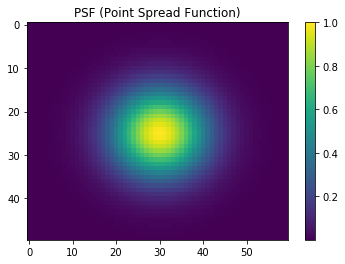

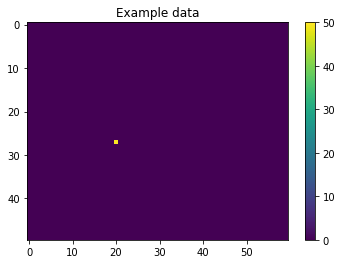

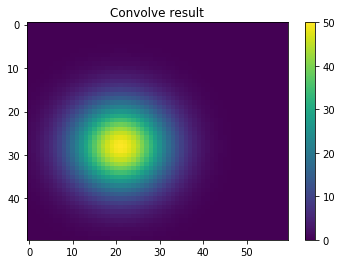

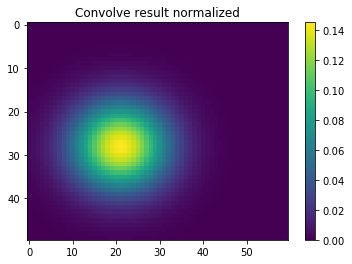

49.793590662466798

In [27]:
plt.imshow(psf_unnorm)
plt.colorbar()
plt.title("PSF (Point Spread Function)")
plt.show()

a = np.zeros(psf.shape)
i = np.random.randint(0,a.shape[0])
j = np.random.randint(0,a.shape[1])
a[i,j] = 50 #measurement
plt.imshow(a)
plt.title("Example data")
plt.colorbar()
plt.show()

operat = convolve2d(a, psf_unnorm, mode='same', boundary='fill', fillvalue=0)
plt.imshow(operat)
plt.title("Convolve result")
plt.colorbar()
plt.show()

operat = convolve2d(a, psf_norm, mode='same', boundary='fill', fillvalue=0)
plt.imshow(operat)
plt.title("Convolve result normalized")
plt.colorbar()
plt.show()
np.sum(operat)

In [13]:
def convolve_cube(cube,PSF):
    new_timestep_data = np.zeros(cube.shape)
    for t in range(new_timestep_data.shape[0]):
        if t%10000==0:
            print("Va en : ",t)
        for c in range(new_timestep_data.shape[-1]):
            if np.sum(np.isnan(cube[t,:,:,c])) > 0: #any nan
                new_timestep_data[t,:,:,c] = cube[t,:,:,c] #leave nans
            else:
                new_timestep_data[t,:,:,c] = convolve2d(cube[t,:,:,c], PSF, mode='same', boundary='fill', fillvalue=0)
    return new_timestep_data

In [18]:
np.save('targetY_verano_Independencia.npy',trainY1_inv)
np.save('targetY_verano_LasCondes.npy',trainY1_cond)

In [14]:
new_cube_data1 = convolve_cube(data_ind,psf_norm)
np.save('inputX_verano_Independencia_norm.npy',new_cube_data1)
new_cube_data2 = convolve_cube(data_cond,psf_norm)
np.save('inputX_verano_LasCondes_norm.npy',new_cube_data2)

new_cube_data1.shape

Va en :  0
Va en :  10000


KeyboardInterrupt: 

In [ ]:
#when data cubes are create create timestep data.. with index (Efficient)

In [36]:
N = 5 #data
T = 8 #timesteps (hours)
Ch = 10 #channels of the cube (number of compound)
input_data = np.zeros((N,T,W,H,Ch))
print("(data, timesteps, width, heigh, channels):",input_data.shape)

(data, timesteps, width, heigh, channels): (5, 8, 40, 35, 10)
